<img src='https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png' alt="SUT logo" width=300 height=300 align=center class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 - Modeling Robot Navigation Using Bayesian Network  <br>
<font color=696880 size=4>
Omid Daliran

# Personal Data


In [1]:
# Set your student number and name
student_number = 401107613
Name = 'Kimia'
Last_Name = 'Vanaei'

# Libraries

In [1]:
import numpy as np
import random
import networkx as nx
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt

# Q1: Modeling Robot Navigation Using Bayesian Network  (100 Points)

# Introduction

In this assignment, we will explore the implementation of Bayesian networks to facilitate robotic navigation in an uncertain environment. A Bayesian network offers a graphical model that allows us to represent and reason about the dependencies among various uncertain variables. By leveraging the power of probabilistic reasoning, we can help a robot make informed decisions regarding its movements based on observations of external factors, such as weather conditions, battery levels, and obstacle presence.

The primary objective of this assignment is to construct a Bayesian network that models the navigation scenario, encompassing key variables that impact the robot's movement. We will implement Conditional Probability Distributions (CPDs) to define the probabilistic relationships among these variables and utilize the variable elimination algorithm to perform inference in the network. Through this process, we aim to calculate the most likely robot position given specific evidence.

# Factors and Their Relationships

In our Bayesian network, we define several critical factors that influence the robot's navigation decisions. Each factor represents a variable that carries uncertainty and plays a significant role in determining the robot's movement strategy. The key factors in our model include:

1. Weather: The weather conditions affect the performance and accuracy of the robot's sensors. Possible states include "clear," "rain," and "fog."

2. Battery Level: This variable indicates the robot's remaining energy. It can be classified as "high" or "low," impacting the likelihood of successful movement.

3. GoalDistance: This factor measures the proximity of the robot to its target destination. It is categorized as "near" or "far," which influences the robot's navigation strategy.

4. Sensor Accuracy: Dependent on the weather conditions, this variable determines how reliable the robot's sensors are in detecting obstacles. It can be either "high" or "low."

5. ObstacleDetection: Based on sensor accuracy, this variable indicates whether an obstacle is detected in the robot's path. The states are "obstacle" or "no_obstacle."

6. Move Success: This factor is influenced by the battery level and determines whether the robot can successfully move in its intended direction. It can be "success" or "failure."

7. Robot Position: The robot's moving position in the grid, which is influenced by move success, obstacle detection, and GoalDistance.

The relationships among these factors are captured through directed edges in the Bayesian network. For instance, the sensor accuracy is influenced by the weather, while obstacle detection relies on sensor accuracy. Moreover, move success depends on the battery level, and the robot's position is contingent on both move success and obstacle detection. These dependencies enable us to calculate joint probabilities and perform inference using the network.

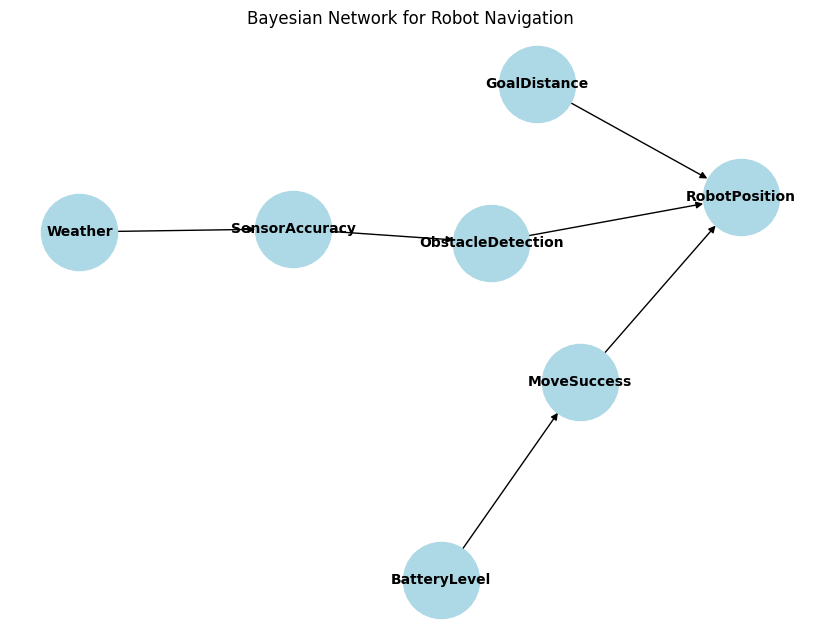

In [3]:
G = nx.DiGraph()
G.add_edges_from([
    ('Weather', 'SensorAccuracy'),
    ('BatteryLevel', 'MoveSuccess'),
    ('SensorAccuracy', 'ObstacleDetection'),
    ('ObstacleDetection', 'RobotPosition'),
    ('GoalDistance', 'RobotPosition'),
    ('MoveSuccess', 'RobotPosition')
])


pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight='bold')
plt.title('Bayesian Network for Robot Navigation')
plt.show()


# Implementing CPDs and Variable Elimination (50 points)

The implementation of Conditional Probability Distributions (CPDs) is crucial for representing the probabilistic relationships between variables in our Bayesian network. Each CPD defines a probability distribution for a variable based on its parent variables, capturing the uncertainties inherent in the system.

In this assignment, we will also implement the variable elimination algorithm, a widely used technique for exact inference in Bayesian networks. This algorithm allows us to compute the posterior probabilities of query variables, such as the robot's position, given certain observed evidence, such as current weather conditions and battery levels.

The variable elimination process consists of several steps:

1. Restrict CPDs based on observed evidence: This involves limiting the CPDs to the subset of variable assignments consistent with the observed values.
2. Eliminate irrelevant variables: Variables not involved in the query or evidence are summed out to simplify the network.
3. Multiply remaining CPDs: After eliminating variables, the remaining CPDs are combined to form a new joint distribution.
4. Normalize the result: The final step ensures that the resulting probabilities sum to one, providing a valid probability distribution for the queried variable.

In [4]:
class CPD:
    def __init__(self, variables, probabilities):
        """
        Factor table for a set of variables.
        :param variables: A list of variables involved in the factor.
        :param probabilities: A dictionary mapping variable assignments (tuples) to probabilities.
        """
        self.variables = variables
        self.probabilities = probabilities


    def restrict(self, variable, value):
        """
        Restrict the factor to a particular value for a given variable (i.e., set evidence).
        :param variable: The variable to restrict.
        :param value: The value of the variable to restrict to.
        :return: A new restricted CPD.
        """
        var_idx = self.variables.index(variable)
        new_vars = [v for v in self.variables if v != variable]
        new_probs = {}

        for assignment, prob in self.probabilities.items():
            if assignment[var_idx] == value:
                new_assignment = tuple(assignment[i] for i in range(len(assignment)) if i != var_idx)
                new_probs[new_assignment] = prob
        
        return CPD(new_vars, new_probs)


    def sum_out(self, variable):
        """
        Sum out a variable from the factor (marginalization).
        :param variable: The variable to sum out.
        :return: A new CPD with the variable summed out.
        """
        var_idx = self.variables.index(variable)
        new_vars = [v for v in self.variables if v != variable]
        new_probs = {}

        for assignment, prob in self.probabilities.items():
            reduced_assignment = tuple(assignment[:var_idx] + assignment[var_idx + 1:])
            new_probs[reduced_assignment] = new_probs.get(reduced_assignment, 0) + prob

        return CPD(new_vars, new_probs)


    def multiply(self, other):
        """
        Multiply two factors together, ensuring proper alignment of variables.
        """
        common_vars = set(self.variables) & set(other.variables)
        unshared_vars = [v for v in other.variables if v not in self.variables]
        new_vars = self.variables + unshared_vars
        new_probs = {}

        for self_assignment, self_prob in self.probabilities.items():
            for other_assignment, other_prob in other.probabilities.items():
                if all(self_assignment[self.variables.index(var)] == other_assignment[other.variables.index(var)]
                       for var in common_vars):
                    combined_assignment = tuple(
                        self_assignment[self.variables.index(var)] if var in self.variables else
                        other_assignment[other.variables.index(var)]
                        for var in new_vars
                    )
                    new_probs[combined_assignment] = self_prob * other_prob

        return CPD(new_vars, new_probs)


    def normalize(self):
        """
        Normalize the factor so that the probabilities sum to 1.
        :return: A normalized CPD.
        """
        total = sum(self.probabilities.values())
        new_probs = {assignment: prob / total for assignment, prob in self.probabilities.items()}
        return CPD(self.variables, new_probs)


In [5]:
def variable_elimination(cpds, query_vars, evidence):
    """
    Perform inference using variable elimination.
    :param cpds: A list of CPD objects representing the Bayesian network.
    :param query_vars: A list of query variables.
    :param evidence: A dictionary of observed evidence variables and their values.
    :return: A normalized CPD representing the posterior distribution.
    """
    # Step 1: Restrict CPDs based on evidence
    restricted_cpds = []
    for cpd in cpds:
        restricted_cpd = cpd
        for var, value in evidence.items():
            if var in cpd.variables:
                restricted_cpd = restricted_cpd.restrict(var, value)
        restricted_cpds.append(restricted_cpd)

    # Step 2: Eliminate variables not in the query or evidence
    variables_to_eliminate = set(
        var for cpd in restricted_cpds for var in cpd.variables
    ) - set(query_vars) - set(evidence.keys())

    for var in variables_to_eliminate:
        cpds_with_var = [cpd for cpd in restricted_cpds if var in cpd.variables]
        
        combined_cpd = cpds_with_var[0]
        for cpd in cpds_with_var[1:]:
            combined_cpd = combined_cpd.multiply(cpd)
            
        reduced_cpd = combined_cpd.sum_out(var)
        restricted_cpds = [cpd for cpd in restricted_cpds if cpd not in cpds_with_var]
        restricted_cpds.append(reduced_cpd)

    # Step 3: Multiply remaining CPDs
    final_cpd = restricted_cpds[0]
    for cpd in restricted_cpds[1:]:
        final_cpd = final_cpd.multiply(cpd)

    # Step 4: Normalize the result
    normalized_cpd = final_cpd.normalize()

    return normalized_cpd

In [6]:
# Example usage:
cpds = [
    CPD(["A"], {('a',): 0.6, ('b',): 0.4}),
    CPD(["A", "B"], {('a', 0): 0.7, ('a', 1): 0.3, ('b', 0): 0.2, ('b', 1): 0.8}),
    CPD(["B", "C"], {(0, 0): 0.9, (0, 1): 0.1, (1, 0): 0.4, (1, 1): 0.6}),
    CPD(["B", "D"], {(0, 0): 0.9, (0, 1): 0.1, (1, 0): 0.4, (1, 1): 0.6}),
]

query_vars = ["D"]
evidence = {"A": 'a'}

result = variable_elimination(cpds, query_vars, evidence)
print("Resulting CPD (Posterior Distribution):")
for assignment, prob in result.probabilities.items():
    print(f"P({assignment[0]}) = {prob}")

Resulting CPD (Posterior Distribution):
P(0) = 0.75
P(1) = 0.25


# CPD Tables (5 points)

The tables are given to you as png files. you need to create the CPDs and use them for inference.

In [7]:
# CPD generation from the CPDs
cpds = []

# CPD for 'Weather' (single variable)
weather_cpd = CPD(variables=["Weather"], probabilities={('clear',):0.5, ('rain',):0.3, ('fog',):0.2})
cpds.append(weather_cpd)

# CPD for 'BatteryLevel' (single variable)
battery_level_cpd = CPD(variables=["BatteryLevel"], probabilities={('high',): 0.7, ('low',): 0.3})
cpds.append(battery_level_cpd)

# CPD for 'GoalDistance' (single variable)
goal_distance_cpd = CPD(variables=["GoalDistance"], probabilities={('near',): 0.4, ('far',): 0.6})
cpds.append(goal_distance_cpd)

# CPD for 'SensorAccuracy' (dependent on 'Weather')
sensor_accuracy_cpd = CPD(
    variables=["Weather", "SensorAccuracy"],
    probabilities={
        ('clear', 'high'): 0.8, ('clear', 'low'): 0.2,
        ('rain', 'high'): 0.4, ('rain', 'low'): 0.6,
        ('fog', 'high'): 0.2, ('fog', 'low'): 0.8
        })
cpds.append(sensor_accuracy_cpd)

# CPD for 'ObstacleDetection' (dependent on 'SensorAccuracy')
obstacle_detection_cpd = CPD(
    variables=["SensorAccuracy", "ObstacleDetection"],
    probabilities={
        ('high', 'obstacle'): 0.7, ('high', 'no_obstacle'): 0.3,
        ('low', 'obstacle'): 0.4, ('low', 'no_obstacle'): 0.6
    }
)
cpds.append(obstacle_detection_cpd)

# CPD for 'MoveSuccess' (dependent on 'BatteryLevel')
move_success_cpd = CPD(
    variables=["BatteryLevel", "MoveSuccess"],
    probabilities={
        ('high', 'success'): 0.9, ('high', 'failure'): 0.1,
        ('low', 'success'): 0.6, ('low', 'failure'): 0.4
    }
)
cpds.append(move_success_cpd)

# CPD for 'RobotPosition' (dependent on 'MoveSuccess', 'ObstacleDetection', and 'GoalDistance')
robot_position_cpd = CPD(
    variables=["MoveSuccess", "ObstacleDetection", "GoalDistance", "RobotPosition"],
    probabilities={
        ('success', 'no_obstacle', 'near', 'up'): 0.2, ('success', 'no_obstacle', 'near', 'down'): 0.2,
        ('success', 'no_obstacle', 'near', 'left'): 0.2, ('success', 'no_obstacle', 'near', 'right'): 0.4,
        ('success', 'no_obstacle', 'far', 'up'): 0.1, ('success', 'no_obstacle', 'far', 'down'): 0.4,
        ('success', 'no_obstacle', 'far', 'left'): 0.1, ('success', 'no_obstacle', 'far', 'right'): 0.4,
        ('success', 'obstacle', 'near', 'up'): 0.0, ('success', 'obstacle', 'near', 'down'): 0.3,
        ('success', 'obstacle', 'near', 'left'): 0.0, ('success', 'obstacle', 'near', 'right'): 0.7,
        ('success', 'obstacle', 'far', 'up'): 0.1, ('success', 'obstacle', 'far', 'down'): 0.4,
        ('success', 'obstacle', 'far', 'left'): 0.3, ('success', 'obstacle', 'far', 'right'): 0.2,
        ('failure', 'no_obstacle', 'near', 'up'): 0.2, ('failure', 'no_obstacle', 'near', 'down'): 0.2,
        ('failure', 'no_obstacle', 'near', 'left'): 0.3, ('failure', 'no_obstacle', 'near', 'right'): 0.3,
        ('failure', 'no_obstacle', 'far', 'up'): 0.1, ('failure', 'no_obstacle', 'far', 'down'): 0.0,
        ('failure', 'no_obstacle', 'far', 'left'): 0.4, ('failure', 'no_obstacle', 'far', 'right'): 0.4,
        ('failure', 'obstacle', 'near', 'up'): 0.0, ('failure', 'obstacle', 'near', 'down'): 0.3,
        ('failure', 'obstacle', 'near', 'left'): 0.3, ('failure', 'obstacle', 'near', 'right'): 0.4,
        ('failure', 'obstacle', 'far', 'up'): 0.0, ('failure', 'obstacle', 'far', 'down'): 0.2,
        ('failure', 'obstacle', 'far', 'left'): 0.25, ('failure', 'obstacle', 'far', 'right'): 0.55
    }
)
cpds.append(robot_position_cpd)

In [8]:
query_vars = ["RobotPosition"]
# evidence = {"Weather": 'clear'}
evidence = {
            'Weather': 'clear',
            'BatteryLevel': 'low',
            'GoalDistance': 'far',
            # 'SensorAccuracy': 'high',
            # 'ObstacleDetection': 'no_obstacle',
            # 'MoveSuccess': 'success'
        }

result = variable_elimination(cpds, query_vars, evidence)
print("Resulting cpd (Posterior Distribution):")
for assignment, prob in result.probabilities.items():
    print(f"P({assignment[0]}) = {prob}")


Resulting cpd (Posterior Distribution):
P(up) = 0.07548701298701298
P(down) = 0.29545454545454547
P(left) = 0.26217532467532473
P(right) = 0.36688311688311687


# Sampling Methods (30 points)

To complement our Bayesian network, we will implement three different sampling methods to estimate the posterior probabilities of the robot's position based on observed evidence:

1. Prior Sampling (10 points): In this method, we will generate samples from the joint distribution defined by the CPDs without conditioning on any evidence. The samples will be used to approximate the distribution of the query variable, such as the robot's position, before any evidence is considered.

In [9]:
def prior_sampling_query(cpds, query, evidence, num_samples=1000):
    """
    Perform Prior Sampling to estimate the probability of a query variable given evidence.
    :param cpds: List of CPD objects representing the conditional probability tables of the Bayesian network.
    :param query: A tuple representing the query variable and its value, e.g., ('MoveSuccess', 'success').
    :param evidence: A dictionary of observed evidence variables and their values, e.g., {'Weather': 'clear'}.
    :param num_samples: The number of samples to generate.
    :return: The estimated probability of the query variable having the specified value given the evidence.
    """
    matching_samples = 0
    total_samples = 0

    for _ in range(num_samples):
        sample = {}

        for cpd in cpds:
            parent_values = tuple(sample[var] for var in cpd.variables[:-1]) if len(cpd.variables) > 1 else ()

            matching_probs = {assignment[-1]: prob for assignment, prob in cpd.probabilities.items() if assignment[:-1] == parent_values}
            
            # Sample a value
            values, probabilities = zip(*matching_probs.items())
            sampled_value = random.choices(values, probabilities)[0]
            sample[cpd.variables[-1]] = sampled_value

        # Check if sample matches evidence
        if all(sample.get(var) == val for var, val in evidence.items()):
            total_samples += 1
            if sample.get(query[0]) == query[1]:
                matching_samples += 1

    return matching_samples / total_samples if total_samples > 0 else 0


In [11]:
query = ('RobotPosition', 'up')
evidence = {'Weather': 'clear'}
prob_prior = prior_sampling_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_prior}')

The estimated probability for moving up is 0.07810935309433206


2. Likelihood Weighting (10 points): This method incorporates evidence into the sampling process by assigning weights to samples based on the likelihood of the observed evidence given the sampled values. This approach allows for more accurate estimation of the posterior probabilities by prioritizing samples that align with the evidence.

In [12]:
def likelihood_weighting_query(cpds, query, evidence, num_samples=1000):
    """
    Perform Likelihood Weighting to estimate the probability of a query variable given evidence.
    :param cpds: List of CPD objects representing the conditional probability tables of the Bayesian network.
    :param query: A tuple representing the query variable and its value, e.g., ('MoveSuccess', 'success').
    :param evidence: A dictionary of observed evidence variables and their values, e.g., {'Weather': 'clear'}.
    :param num_samples: The number of weighted samples to generate.
    :return: The estimated probability of the query variable having the specified value given the evidence.
    """
    weighted_samples = []
    total_weight = 0

    for _ in range(num_samples):
        sample = {}
        weight = 1.0

        for cpd in cpds:
            parent_values = tuple(sample[var] for var in cpd.variables[:-1]) if len(cpd.variables) > 1 else ()

            matching_probs = {key[-1]: prob for key, prob in cpd.probabilities.items() if key[:-1] == parent_values}

            # If the variable is in evidence, update weight
            current_variable = cpd.variables[-1]
            if current_variable in evidence:
                evidence_value = evidence[current_variable]
                if evidence_value in matching_probs:
                    weight *= matching_probs[evidence_value]
                else:
                    weight = 0  # Evidence conflicts. discard this sample
                    break
                sample[current_variable] = evidence_value  
            else:
                # Is not evidence. just sample
                values, probabilities = zip(*matching_probs.items())
                sampled_value = random.choices(values, probabilities)[0]
                sample[current_variable] = sampled_value

        if weight > 0:
            weighted_samples.append((sample, weight))
            total_weight += weight

    query_variable, query_value = query
    query_weight = sum(weight for sample, weight in weighted_samples if sample.get(query_variable) == query_value)

    return query_weight / total_weight if total_weight > 0 else 0.0


In [22]:
query = ('RobotPosition', 'up')
evidence = {'Weather': 'clear'}
prob_lw = likelihood_weighting_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_lw}')

The estimated probability for moving up is 0.0817


3. Gibbs Sampling (10 points): This technique is an iterative method that generates samples from the joint distribution by conditioning on the current values of other variables. It allows for efficient sampling, especially in high-dimensional spaces, by focusing on one variable at a time while keeping others fixed.



In [27]:
def gibbs_sampling_query(cpds, query, evidence, num_samples=1000): 
    """ 
    Performs Gibbs sampling to estimate the probability of a query variable given evidence. 
 
    Args: 
    - cpds: List of CPD objects representing the Bayesian network. 
    - query: A tuple (variable, value) representing the query. 
    - evidence: A dictionary {variable: value} representing the observed evidence. 
    - num_samples: Number of samples to generate (default: 1000). 
 
    Returns: 
    - Estimated probability of the query variable taking the queried value given the evidence. 
    """ 
    variables = set() 
    for cpd in cpds: 
        variables.update(cpd.variables) 
    variables = list(variables) 
 
    # initialize the state with evidence or random assignments 
    state = {} 
    for var in variables: 
        if var in evidence: 
            state[var] = evidence[var] 
        else: 
            # Find the CPD for this variable 
            relevant_cpd = next((cpd for cpd in cpds if cpd.variables[-1] == var), None) 
            if relevant_cpd: 
                possible_values = set(outcome[-1] for outcome in relevant_cpd.probabilities.keys()) 
                state[var] = random.choice(list(possible_values)) 
            else: 
                raise ValueError(f"No CPD found for variable {var}") 
 
    # precompute CPD lookup tables for efficiency 
    cpd_lookup = {cpd.variables[-1]: cpd for cpd in cpds} 
 
    # gibbs sampling loop 
    query_var, query_value = query 
    query_count = 0  # To track how many times the query variable matches the desired value 
 
    for _ in range(num_samples): 
        for var in variables: 
            if var not in evidence: 
                # Compute conditional probability for the current variable 
                cpd = cpd_lookup[var] 
                relevant_vars = cpd.variables[:-1] 
                condition = tuple(state[rv] for rv in relevant_vars) 
                probabilities = { 
                    outcome[-1]: prob 
                    for outcome, prob in cpd.probabilities.items() 
                    if outcome[:-1] == condition 
                } 
                total_prob = sum(probabilities.values()) 
                if total_prob > 0: 
                    normalized_probs = { 
                        val: prob / total_prob for val, prob in probabilities.items() 
                    } 
 
                    # update the state by sampling from the conditional distribution 
                    state[var] = random.choices( 
                        list(normalized_probs.keys()), 
                        weights = normalized_probs.values(), 
                        k = 1, 
                    )[0] 
 
        if state[query_var] == query_value: 
            query_count += 1 
 
    return query_count / num_samples

In [31]:
query = ('RobotPosition', 'up')
evidence = {'Weather': 'clear'}
prob_gibbs = gibbs_sampling_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_gibbs}')

The estimated probability for moving up is 0.0809


# Robot Movement and Inference Methods (15 points)
In this assignment, we have implemented a robot navigation system that utilizes Bayesian networks to make informed decisions about its movement within a grid. The robot begins at the position
(0,0) and aims to reach the goal located at the opposite corner of the grid, while navigating potential obstacles and managing its battery level.

To determine the most likely direction the robot should move at each step, we employ various inference methods from Bayesian statistics. The robot’s movement decisions rely on the current state, which includes environmental factors such as weather conditions, battery level, distance to the goal, sensor accuracy, and obstacle detection.

run the following code to check you implementation.

In [32]:
class RobotNavigation:
    def __init__(self, grid_size=5, cpds=None, obstacles=None):
        self.grid_size = grid_size
        self.robot_position = (0, 0)  # Starting position at top-left corner
        self.goal_position = (grid_size-1, grid_size-1)  # Goal is at the bottom-right corner
        self.cpds = cpds  # Conditional probability distributions (CPDs)
        # Obstacles placed at specific positions (not randomly, to be defined)
        self.obstacles = obstacles if obstacles else [(2, 2), (1, 3)]
        self.battery_level = 10
        self.state = {
            'Weather': 'clear',
            'BatteryLevel': 'high',
            'GoalDistance': 'far',
            'SensorAccuracy': 'high',
            'ObstacleDetection': 'no_obstacle',
            'MoveSuccess': 'success'
        }

    def move_robot(self, factors, method):
        # Update state with any specific factors provided (like {'Weather': 'clear'})
        self.state.update(factors)

        query_vars = ['RobotPosition']
        evidence = self.state  # Current state is the evidence

        # Choose the inference method
        if method == 'exact_inference':
            result = variable_elimination(self.cpds, query_vars, evidence).probabilities
        elif method == 'prior':
            result = {direction: prior_sampling_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}
        elif method == 'likelihood':
            result = {direction: likelihood_weighting_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}
        elif method == 'gibbs':
            result = {direction: gibbs_sampling_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}

        # Find the most probable move
        best_move = max(result, key=result.get)
        if method == 'exact_inference': best_move = best_move[0]

        # Move the robot if possible (no obstacle in the way)
        new_position = self.get_new_position(best_move)
        if new_position not in self.obstacles and self.is_within_grid(new_position):
            self.robot_position = new_position

        # Visualize the current state of the grid
        self.visualize_grid()

        # Update the state after moving
        self.update_state(factors)

    def update_state(self, factors):
        self.state = factors
        # Update state, for example, if GoalDistance is near or an obstacle is detected
        distance_to_goal = abs(self.robot_position[0] - self.goal_position[0]) + \
                           abs(self.robot_position[1] - self.goal_position[1])
        self.state['GoalDistance'] = 'near' if distance_to_goal <= 1 else 'far'


        # Decrease battery level with each move
        self.battery_level = max(0, self.battery_level-1)

        # If battery level drops below threshold, update state
        if self.battery_level <= 5:
            self.state['BatteryLevel'] = 'low'

        # # Simulate obstacle detection based on the robot's position
        # self.state['ObstacleDetection'] = 'obstacle' if self.robot_position in self.obstacles else 'no_obstacle'

    def visualize_grid(self):
        grid = [[' ' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        grid[self.goal_position[0]][self.goal_position[1]] = 'G'  # Mark the goal
        grid[self.robot_position[0]][self.robot_position[1]] = 'R'  # Mark the robot
        for obs in self.obstacles:
            grid[obs[0]][obs[1]] = 'X'  # Mark obstacles
        for row in grid:
            print(' '.join(row))
        print('\n')

    def get_new_position(self, move):
        """Return the new position of the robot based on the direction of the move."""
        x, y = self.robot_position
        if move == 'up':
            return (x-1, y)
        elif move == 'down':
            return (x+1, y)
        elif move == 'left':
            return (x, y-1)
        elif move == 'right':
            return (x, y+1)

    def is_within_grid(self, position):
        """Check if the new position is within the grid bounds."""
        x, y = position
        return 0 <= x < self.grid_size and 0 <= y < self.grid_size


In [34]:
# Create an instance of RobotNavigation
robot = RobotNavigation(grid_size=5, cpds=cpds, obstacles=[(2, 2), (1, 3)])

# Continue moving the robot until it reaches the goal
step = 0
while robot.robot_position != robot.goal_position:
    print(f"Robot's current position: {robot.robot_position}")
    # Move the robot using the 'exact_inference' method as an example
    robot.move_robot(factors={'Weather': 'rain'}, method='exact_inference')
    step+=1

print(f"Robot has reached the goal in {step} steps!")


Robot's current position: (0, 0)
         
R     X  
    X    
         
        G


Robot's current position: (1, 0)
         
      X  
R   X    
         
        G


Robot's current position: (2, 0)
         
      X  
    X    
R        
        G


Robot's current position: (3, 0)
         
      X  
    X    
         
R       G


Robot's current position: (4, 0)
         
      X  
    X    
         
R       G


Robot's current position: (4, 0)
         
      X  
    X    
         
  R     G


Robot's current position: (4, 1)
         
      X  
    X    
         
    R   G


Robot's current position: (4, 2)
         
      X  
    X    
         
      R G


Robot's current position: (4, 3)
         
      X  
    X    
         
        R


Robot has reached the goal in 9 steps!
